# Essais Modélisation KNN

L'algorithme de KNN nécessite de définir une métrique sur les données. Le principe général pour prédire le loyer inconnu d'un appartement à partir d'une base d'appartements aux loyers connus est alors le suivant :
- A l'aide de la métrique définie, l'algorithme calcule la distance entre l'appartement cible et tous les appartements de loyer connu ;
- Ensuite, il ne garde que les $k$ plus proches appartements ;
- Le loyer qu'il prédit est alors la moyenne des loyers des appartements retenus. On peut également ajouter une pondération, pour que les appartements les plus similaires aient une influence plus importante sur la prédiction.

In [19]:
import pandas as pd
import geopandas as gpd

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error,mean_squared_error

from math import sqrt

On utilise la base de données numériques, dont on ne garde que les variables d'intérêt révélées par le modèle Lasso :

In [4]:
df_num = gpd.read_file("donnees_num.geojson")
df_knn = df_num[['ref','piece','meuble_bin','distance_centre_paris']]

In [12]:
df_knn.head(5)

,ref,piece,meuble_bin,distance_centre_paris
0,22.3,3,0,1.299442
1,32.1,1,0,1.299442
2,30.7,3,1,1.299442
3,27.7,3,1,1.299442
4,25.9,4,1,1.299442


## Distance sur les données

Pour chaque appartements, on a donc une variable binaire catégorielle (`meuble_bin`), une variable continue (`distance_centre_paris`), et une autre variable numérique que l'on a déjà justifié considéré comme variable numérique et non catégorielle (`piece`).

Il faut définir une métrique sur ces variables. Comme on a à la fois des variables catégorielles et non catégorielles, on a ici choisi d'utiliser une distance qui correspond à la distance de Hamming pour les variables catégorielles, et à la distance de Manhattan pour les variables numériques : 

$$\forall x,y \in \mathbb{R}^k : d(x,y) = \sum_{i=1}^{k} |x_i-y_i|$$

Pour les variables binaires, $|x_i-y_i|$ vaudra donc 0 si $x_i=y_i$ et 1 sinon.

In [15]:
distance = lambda x,y : sum(abs(x-y))

In [23]:
x = np.array([0,1,2])
y = np.array([3,-4,5])
distance(x,y)

11

## Préparation des données :
- on divise les données en un échantillon test et un échentillon d'entrainement
- on utilise `MinMaxScaler` pour mettre à l'échelle toutes les variables explicatives, en les ramenant entre 0 et 1 par exemple.

In [29]:
Y = df_knn['ref']
X = df_knn[['piece', 'distance_centre_paris', 'meuble_bin']]

xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

xTrain_scaled = scaler.fit_transform(xTrain)
xTrain = pd.DataFrame(xTrain_scaled, columns = xTrain.columns)

xTest_scaled = scaler.fit_transform(xTest)
xTest = pd.DataFrame(xTest_scaled,columns = xTest.columns)

In [32]:
xTrain.head(5)

,piece,distance_centre_paris,meuble_bin
0,1.000000,0.456375,0.0
1,0.666667,0.639943,1.0
2,0.666667,0.639879,1.0
3,0.666667,0.163248,0.0
4,0.000000,0.402773,0.0


## Choix de l'hyperparamètre $k$

De la même manière que pour le modèle Lasso, on doit choisir un hyperparamètre $k$ qui correspond au nombre de voisins que l'on sélectionne dans l'algorithme KNN. 
Pour le choisir, on réalise un graphique représentant l'erreur RMSE sur le jeu de données test en fonction de la valeur de $k$ choisie.

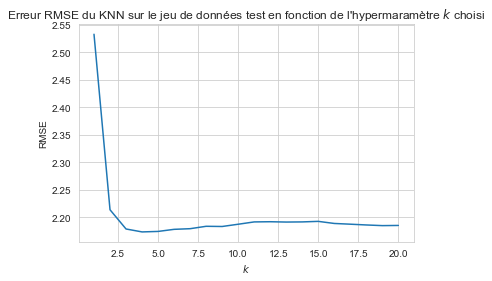

In [45]:
rmse = [] 

for k in range(1,21):
    
    #Entrainement du modèle sur le jeud de données d'entrainement :
    knn = neighbors.KNeighborsRegressor(n_neighbors = k,metric="manhattan",weights="distance")  
    knn.fit(xTrain, yTrain)  
    
    #Calcul de MAE sur le jeu de données test :
    prediction= knn.predict(xTest) 
    error = sqrt(mean_squared_error(yTest,prediction)) 
    rmse.append(error) 
    
sns.set_style("whitegrid")
sns.lineplot(x=[k for k in range(1,21)], y=rmse).set(title = r"Erreur RMSE du KNN sur le jeu de données test en fonction de l'hypermaramètre $k$ choisi", xlabel=r'$k$', ylabel='RMSE')

plt.show()

On remarque un point d'inflexion pour $k=3$, c'est donc le nombre de voisins que nous allons choisir. On remarque que ce nombre est plutot faible, de même que les erreurs RMSE commises lors de la prédiction. Il semble donc que ce modèle soit plutôt performant.

## Modèle KNN pour $k=3$

On peut désormais faire tourner le modèle KNN avec $k=3$, et regarder les indicateurs de performance associés : 

In [56]:
k = 3

#Entrainement du modèle sur le jeud de données d'entrainement :
knn = neighbors.KNeighborsRegressor(n_neighbors = 3,metric="manhattan",weights="distance")  
knn.fit(xTrain, yTrain)  
    
#Calcul de MAE sur le jeu de données test :
prediction= knn.predict(xTest) 

resultats = pd.DataFrame({'Loyers effectifs': list(yTest), 'Loyers prédis': list(prediction)})

#Calcul des indicateurs de performance : 
resultats['Ecarts_abs'] = abs(resultats['Loyers prédis']-resultats['Loyers effectifs'])
resultats['Ecarts^2'] = resultats['Ecarts_abs']**2
resultats['Percentage'] = resultats['Ecarts_abs']/resultats['Loyers effectifs']
    
MAE = resultats['Ecarts_abs'].mean()
MSE = resultats['Ecarts^2'].mean()
RMSE = MSE**0.5
MAPE = resultats['Percentage'].mean()

print(pd.DataFrame({'MAE' : [MAE], 'MSE' : [MSE], 'RMSE' : [RMSE], 'MAPE' : [MAPE]}))

        MAE       MSE      RMSE      MAPE
0  1.805534  4.746948  2.178749  0.071996


Text(0.5, 1.0, 'Répartition des écarts entre valeurs prédites \n et effectives pour le jeu de données test \n (en valeur absolue)')

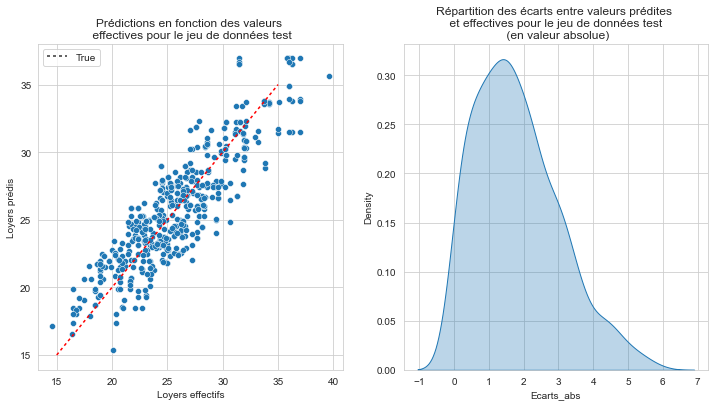

In [58]:
fig,ax = plt.subplots(1, 2, figsize=(12, 6)) 
        
#Scatter plot :
sns.scatterplot(data=resultats, x='Loyers effectifs',y='Loyers prédis',ax = ax[0])
identite = [i for i in range(int(resultats['Loyers prédis'].min()),int(resultats['Loyers prédis'].max()))]
sns.lineplot(x=identite,y=identite,style=True, dashes=[(2,2)],color="red",ax = ax[0])
ax[0].set_title("Prédictions en fonction des valeurs \n effectives pour le jeu de données test")
        
#Densité :
sns.kdeplot(resultats['Ecarts_abs'],ax = ax[1], fill=True, alpha=.3)
ax[1].set_title("Répartition des écarts entre valeurs prédites \n et effectives pour le jeu de données test \n (en valeur absolue)") 